# Week 1 - Function 2 ((10DP, 2D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [18]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils.plotting_utils import (
    plot_2D_initial_data,
    plot_output_outliers,
    plot_2D_mean_uncertainty,
)

# Plan
Recap we have the following data: ((10, 2)) - 10DP & 2D, that can be found `./data/initial_data/function_2/`.

0. Setup:
    1. Load the data
    2. Analyse raw data - visualise data and see patterns
    3. Normalise input & output - this will make it easier to work with the data
    4. Analyse normalise data - verify (visually should look the same)
    5. Early result
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [19]:
X_train_raw = np.load(r"./data/initial_data/function_2/initial_inputs.npy")
y_train_raw = np.load(r"./data/initial_data/function_2/initial_outputs.npy")

# 0.2. Setup > Analyse raw data

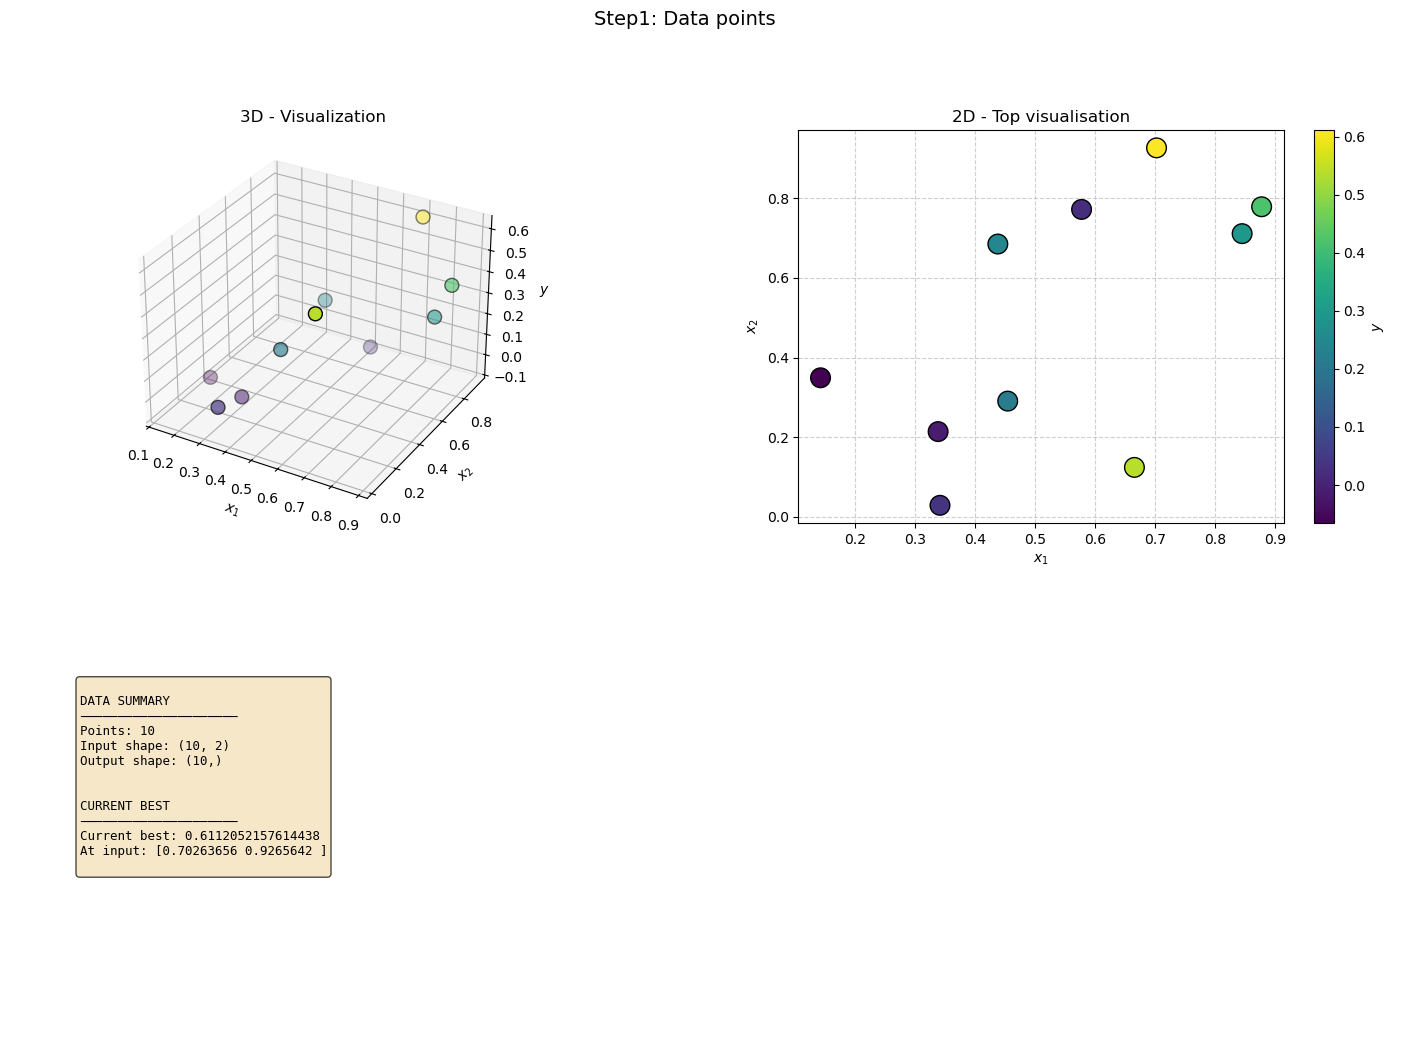

In [20]:
plot_2D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 0.3. Setup > Normalise the data

In [21]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

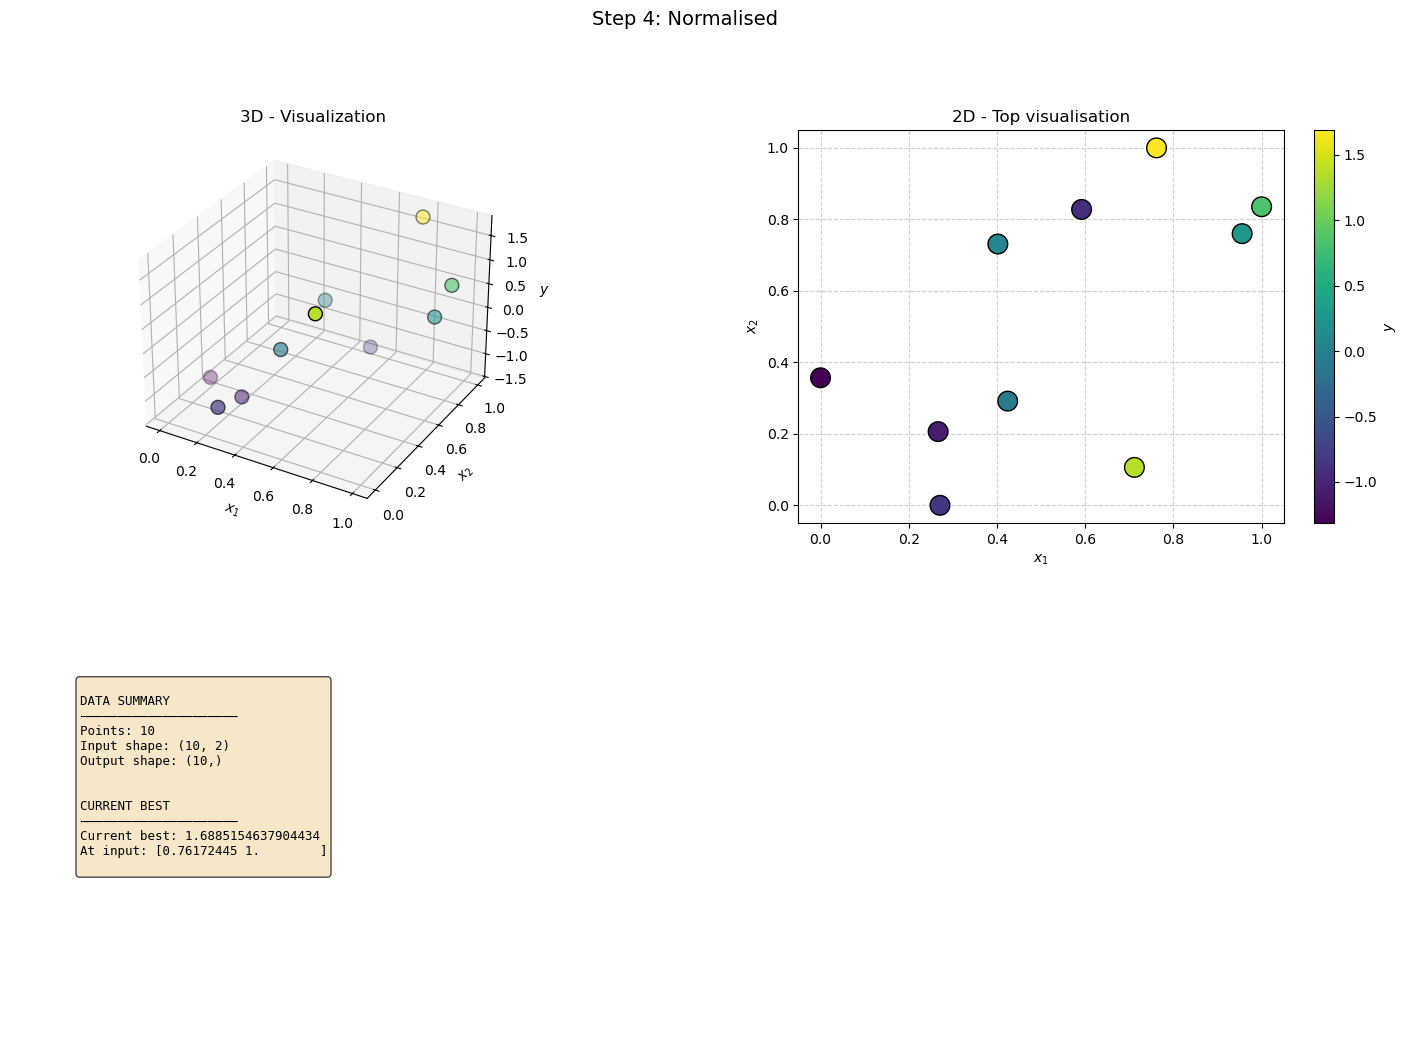

In [22]:
plot_2D_initial_data(X_train, y_train, "Step 4: Normalised", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train)}
Input shape: {X_train.shape}
Output shape: {y_train.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train)}
At input: {X_train[np.argmax(y_train)]}
""")

# 0.5. Setup > Early result

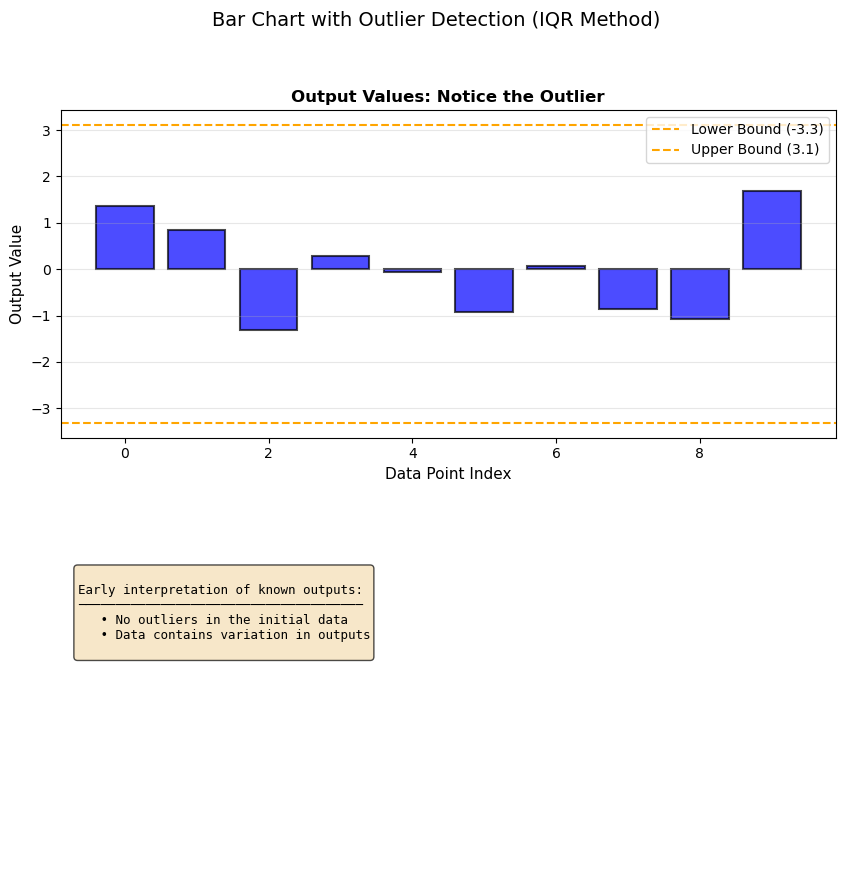

In [23]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • No outliers in the initial data
   • Data contains variation in outputs
""")

# 1. Build probabilistic Model

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs

## Kernel choice
I don't see anything concerning with the different outputs so in this case I will use a RBF.

Optimized Kernel: 1.07**2 * RBF(length_scale=0.162)


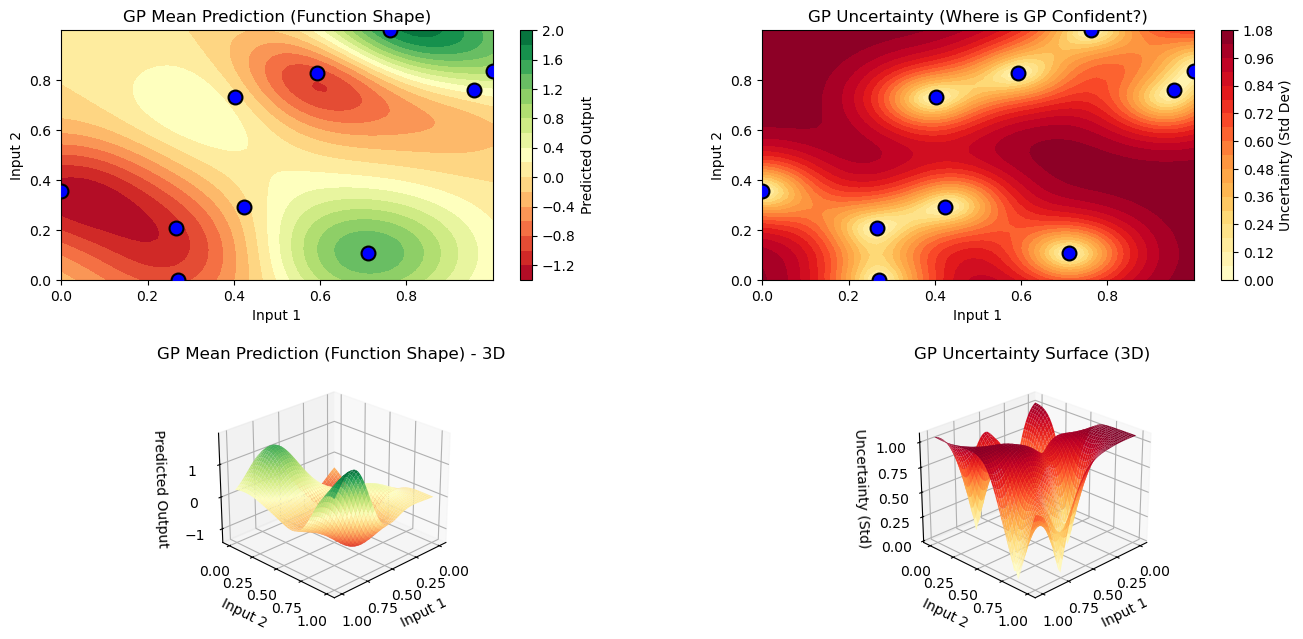

In [24]:
# Step 1: Kernel + Model
# ======================
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(
    length_scale=1.0,
    length_scale_bounds=(1e-9, 1e2)
)

model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=False,
    n_restarts_optimizer=10
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")


#  Create prediction grid
n_grid = 50
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)

X1_test, X2_test = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)

plot_2D_mean_uncertainty(
   X_train,
   model,
   X1_test,
   X2_test,
   mu,
   sigma,
)


# 2. Acquisition function

From early exploration we know that:
- No outliers in the initial data
- Data contains variation in outputs
- Low dimension

So in this case we want to explore to build an image of the function. So let's us Upper Confidence Bound for now since we want to do more exploration of the function.

In [25]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    """
    Upper Confidence Bound (UCB) acquisition function.
    
    UCB = mean + kappa * std
    
    Parameters:
    -----------
    mu : predicted mean
    sigma : predicted standard deviation
    kappa : exploration parameter (higher = more exploration)
    """
    return mu + kappa * sigma


ucb_values = upper_confidence_bound(mu, sigma, kappa=2.0)

print(f"\nExpected Improvement (UCB):")
print(f"  Min: {ucb_values.min():.8f}")
print(f"  Max: {ucb_values.max():.8f}")
print(f"  Mean: {ucb_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ucb_values)
x_next_norm = X_grid[best_idx]
ei_best = ucb_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")


Expected Improvement (UCB):
  Min: -1.19600749
  Max: 2.96195018
  Mean: 1.42086517

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.802781
  Input 2: 0.926563

In normalized space:
  Input 1: 0.897958
  Input 2: 0.999999

Predicted output at this point:
  Normalized: 1.748331 ± 0.606809
  Original: 0.624686
  95% CI: [-0.564661, 1.814032]

Expected Improvement at this point: 2.96195018
